In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import sys
from pathlib import Path

repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

In [8]:

from omegaconf import OmegaConf
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd

from sc_classification.var_genes import normalize_and_choose_genes, shuang_genes_to_keep
from data_loading.utils import merge_labels_to_adata

In [9]:
config_path = Path(repo_dir, 'config.yaml')
conf = OmegaConf.load(config_path)

### load data and choose variable genes

In [10]:
adata_path = Path(conf.outputs.output_dir, conf.outputs.processed_adata_file_name)
adata = ad.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 300441 × 49969
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Project', 'Cohort', 'Weizmann.Code', 'Method', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [22]:
shunag_var_genes = 'MARS_SPID_combined' # MARS_SPID_combined, MARS_SPID_common or None
genes_to_keep = shuang_genes_to_keep(genes_names=adata.var_names, flavor=shunag_var_genes)

In [23]:
adata.layers["counts"] = adata.X.copy()  # preserve counts (needed for normalize_and_choose_genes with if suret_vs flavor + SCVI)
adata_for_clustering = normalize_and_choose_genes(adata, conf, genes_to_keep=genes_to_keep, min_mean=0.02, max_mean=3, min_disp=0.5)
adata_for_clustering

AnnData object with n_obs × n_vars = 300441 × 3862
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Project', 'Cohort', 'Weizmann.Code', 'Method', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

### Merge annotations

In [24]:
import pandas as pd
import pyreadr

from data_loading.utils import load_dataframe_from_file, merge_labels_to_adata

In [25]:
spid_label_path = "/home/labs/amit/shuangyi/Project_MM_2023/ann_SPID_20231110_CD45.Rds"
mars_label_path = "/home/labs/amit/shuangyi/Project_MM_2023/ann_MARS_20231110_CD45.Rds"

mars_result = pyreadr.read_r(mars_label_path)
spid_result = pyreadr.read_r(spid_label_path)

df_mars_labels = mars_result[None] 
df_spid_labels = spid_result[None] 

label_col = "Populations"
# pd.concat([df_mars_labels[label_col].value_counts(normalize=True).rename("MARS_norm"),
#            df_mars_labels[label_col].value_counts().rename("MARS_count"),
#            df_spid_labels[label_col].value_counts(normalize=True).rename("SPID"),
#            df_spid_labels[label_col].value_counts().rename("SPID_count")], axis=1)

In [26]:
all_labels = pd.concat([df_mars_labels[[label_col, "cID"]], df_spid_labels[[label_col, "cID"]]])
adata_for_clustering = merge_labels_to_adata(adata_for_clustering, all_labels, 
                                            col_in_adata_to_merge_by="index", 
                                            cols_in_labels_df_to_merge_by="cID", 
                                            cols_to_validate_not_empty=None, labels_col_names_to_merge=[label_col])

In [27]:
adata_for_clustering

AnnData object with n_obs × n_vars = 300441 × 3862
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Project', 'Cohort', 'Weizmann.Code', 'Method', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Populations', 'cID'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

### train scvi

In [28]:
scvi.model.SCVI.setup_anndata(
    adata_for_clustering,
    layer="counts",
    batch_key="Method",
)

In [29]:
# model = scvi.model.SCVI(adata_for_clustering, dropout_rate=0.2)

In [30]:
# model.train(early_stopping=True)

In [31]:
# model_path = os.path.join(conf.outputs.output_dir, conf.outputs.scvi_model_name)
# model.save(model_dir, overwrite=True)


In [32]:
if shunag_var_genes != 'None':
    model_name = f"{conf.outputs.scvi_model_name}_{shunag_var_genes}_genes"
else:
    model_name = conf.outputs.scvi_model_name

# model_name = f"{conf.outputs.scvi_model_name}_MARS_SPID_combined_genes"
print(model_name)
model_path = os.path.join(conf.outputs.output_dir,  model_name)
model = scvi.model.SCVI.load(model_path, adata=adata_for_clustering)
model

scvi_model_MARS_SPID_combined_genes
INFO     File /home/labs/amit/noamsh/repos/MM_2023/outputs/scvi_model_MARS_SPID_combined_genes/model.pt already    
         downloaded                                                                                                


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.3, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [33]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata_for_clustering.obsm[SCVI_LATENT_KEY] = latent
latent.shape

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


(300441, 10)

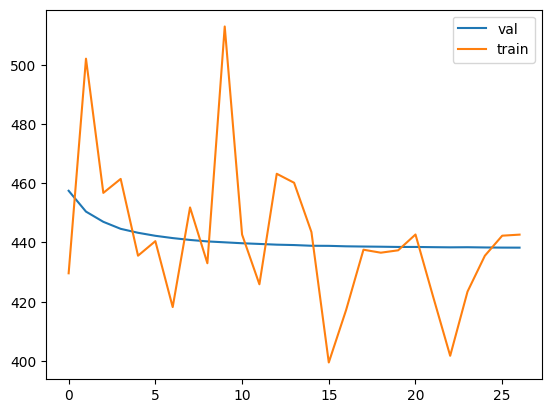

In [34]:
import matplotlib.pyplot as plt
# model.history.keys()
plt.plot(model.history['validation_loss'], label="val")
plt.plot(model.history['train_loss_step'], label="train")
plt.legend()
plt.show()


### visualize SCVI

In [36]:
sc.pp.neighbors(adata_for_clustering, use_rep=SCVI_LATENT_KEY, n_neighbors=30)
sc.tl.umap(adata_for_clustering, min_dist=0.3)

In [34]:
sc.tl.leiden(adata_for_clustering, resolution=1)

In [37]:
sc.pl.umap(
    adata_for_clustering,
    color=["Method", label_col] #, 'leiden'],
    ncols=1,
    frameon=False,
)

SyntaxError: invalid syntax (40354340.py, line 4)

In [21]:
# sc.tl.embedding_density(adata_for_clustering, basis='umap', groupby='Method')
# sc.pl.embedding_density(adata_for_clustering, basis="umap", key='umap_density_Method')

In [22]:
# sc.tl.embedding_density(adata_for_clustering, basis='umap', groupby=label_col)
# sc.pl.embedding_density(adata_for_clustering, basis="umap", key=f"umap_density_{label_col}")

### use PCA visualization

In [72]:
sc.tl.pca(adata_for_clustering)

In [73]:
sc.pp.neighbors(adata_for_clustering, n_pcs=50, n_neighbors=50)

In [74]:
sc.tl.umap(adata_for_clustering, min_dist=1)

In [21]:
sc.tl.leiden(adata_for_clustering, resolution=0.5)

In [14]:
# # load pca_adata
# pca_adata_path = Path(conf.outputs.output_dir, "pca_nighborhood_adata.h5ad")
# adata_for_clustering = ad.read_h5ad(pca_adata_path)

## save pca_adata
# pca_adata_path = Path(conf.outputs.output_dir, "pca_nighborhood_adata.h5ad")
# adata_for_clustering.write(pca_adata_path)


/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

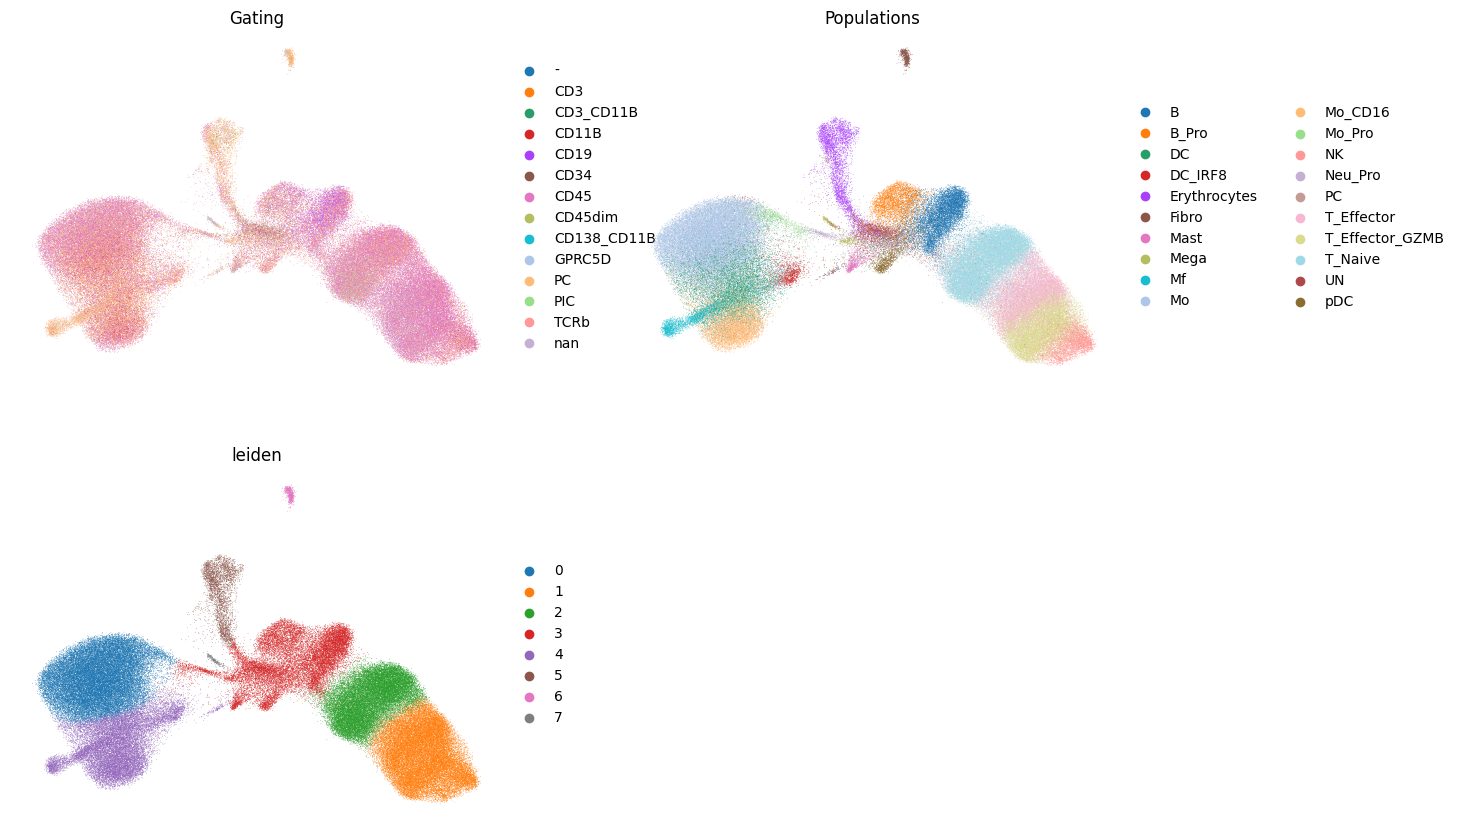

In [22]:
sc.pl.umap(
    adata_for_clustering,
    color=['Gating', label_col, "leiden"],
    ncols=2,
    frameon=False 
)

In [ ]:
# sc.tl.embedding_density(adata_for_clustering, basis='umap', groupby='Gating')
# sc.pl.embedding_density(adata_for_clustering, basis="umap", key='umap_density_Gating')

In [ ]:
# sc.tl.embedding_density(adata_for_clustering, basis='umap', groupby='Annotation')
# sc.pl.embedding_density(adata_for_clustering, basis="umap", key='umap_density_Annotation')